In [1]:
!pip install pandas scikit-learn transformers torch seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attemp

2025-06-13 18:57:08.568470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749841028.785619      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749841028.851515      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Dataset size: 39984
Label distribution:
 label
0    20000
1    19984
Name: count, dtype: int64
Duplicate reviews: 0
Training set size: 31987
Validation set size: 7997
Overlapping reviews: 0
Using device: cuda
GPU Memory Allocated: 0.0 MB


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Epoch 1


Epoch 1 [Training]:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1 [Validation]:   0%|          | 0/250 [00:00<?, ?it/s]

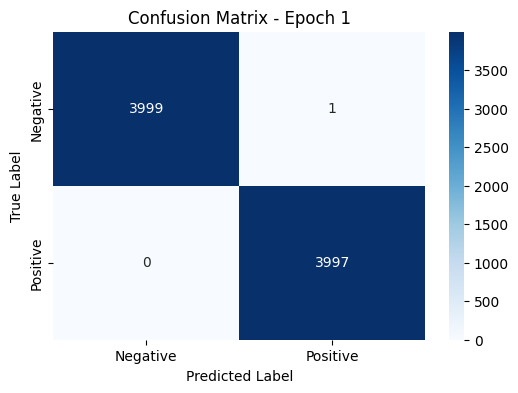

Epoch 1/5 | Train Loss: 0.0097 | Val Acc: 0.9999 | Val F1: 0.9999
→ New best F1: 0.9999
GPU Memory Used: 2163.60986328125 MB
Starting Epoch 2


Epoch 2 [Training]:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 2 [Validation]:   0%|          | 0/250 [00:00<?, ?it/s]

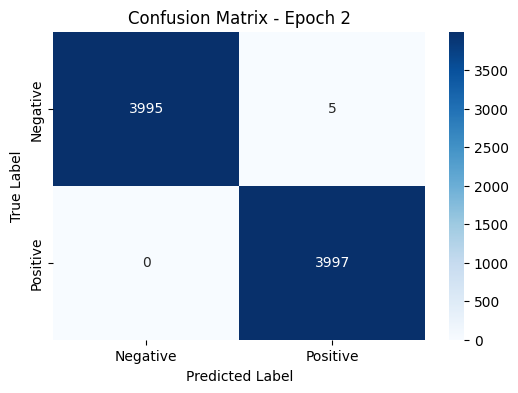

Epoch 2/5 | Train Loss: 0.0010 | Val Acc: 0.9994 | Val F1: 0.9994
→ No improvement. Counter: 1/3
GPU Memory Used: 2163.60986328125 MB
Starting Epoch 3


Epoch 3 [Training]:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 3 [Validation]:   0%|          | 0/250 [00:00<?, ?it/s]

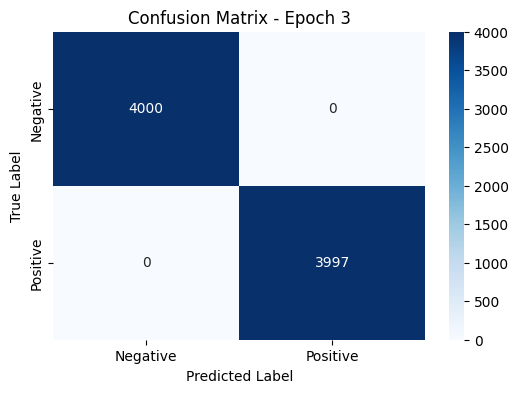

Epoch 3/5 | Train Loss: 0.0013 | Val Acc: 1.0000 | Val F1: 1.0000
→ New best F1: 1.0000
GPU Memory Used: 2163.60986328125 MB
Starting Epoch 4


Epoch 4 [Training]:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 4 [Validation]:   0%|          | 0/250 [00:00<?, ?it/s]

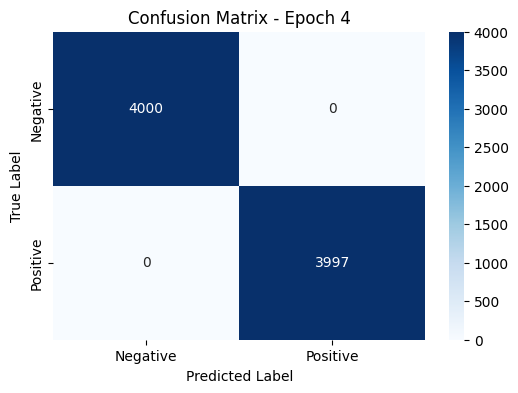

Epoch 4/5 | Train Loss: 0.0000 | Val Acc: 1.0000 | Val F1: 1.0000
→ No improvement. Counter: 1/3
GPU Memory Used: 2163.60986328125 MB
Starting Epoch 5


Epoch 5 [Training]:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 5 [Validation]:   0%|          | 0/250 [00:00<?, ?it/s]

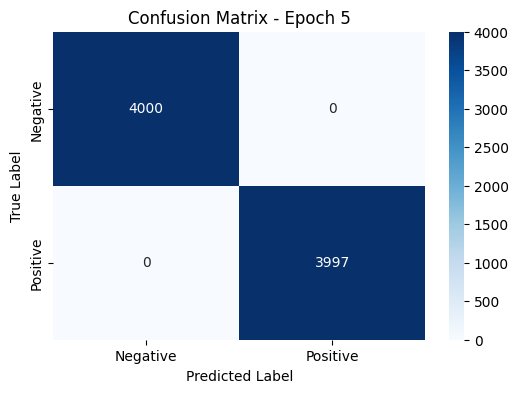

Epoch 5/5 | Train Loss: 0.0000 | Val Acc: 1.0000 | Val F1: 1.0000
→ No improvement. Counter: 2/3
GPU Memory Used: 2163.60986328125 MB
Saved best RoBERTa+LSTM model to /kaggle/working/roberta_lstm.pt (Val F1 = 1.0000)


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import RobertaTokenizerFast, RobertaModel
from tqdm.auto import tqdm

# 1. CONFIGURATION
DATA_PATH    = "/kaggle/input/dataset-preparation/small_reviews_clean.csv"
MODEL_OUT    = "/kaggle/working/roberta_lstm.pt"
NUM_EPOCHS   = 5
PATIENCE     = 3
BATCH_SIZE   = 16
MAX_LENGTH   = 256
LR           = 2e-5
WEIGHT_DECAY = 0.01

# 2. LOAD & SPLIT
df = pd.read_csv(DATA_PATH)

print("Dataset size:", len(df))
print("Label distribution:\n", df['label'].value_counts())
print("Duplicate reviews:", df['clean_review'].duplicated().sum())

df = df.drop_duplicates(subset=['clean_review'], keep='first')
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df.label, random_state=42)
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
if len(val_df) < 100:
    print("Warning: Validation set is small (<100 samples), which may lead to unreliable metrics.")

train_reviews = set(train_df['clean_review'])
val_reviews = set(val_df['clean_review'])
print("Overlapping reviews:", len(train_reviews.intersection(val_reviews)))

# 3. DEVICE SETUP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if torch.cuda.is_available():
    print("GPU Memory Allocated:", torch.cuda.memory_allocated() / 1024**2, "MB")
    torch.cuda.empty_cache()

# 4. TOKENIZER & DATASET
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

class HybridDataset(Dataset):
    def __init__(self, texts, labels):
        enc = tokenizer(texts.tolist(),
                        truncation=True,
                        padding="max_length",
                        max_length=MAX_LENGTH,
                        return_tensors="pt")
        self.input_ids      = enc.input_ids.to(device)
        self.attention_mask = enc.attention_mask.to(device)
        self.labels         = torch.tensor(labels.values, dtype=torch.long).to(device)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids":      self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels":         self.labels[idx],
        }

train_ds = HybridDataset(train_df.clean_review, train_df.label)
val_ds   = HybridDataset(val_df.clean_review,   val_df.label)
train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_ld   = DataLoader(val_ds,   batch_size=BATCH_SIZE*2)

# 5. MODEL DEFINITION
class RobertaLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.roberta    = RobertaModel.from_pretrained("roberta-base").to(device)
        hid_size        = self.roberta.config.hidden_size
        self.lstm       = nn.LSTM(hid_size, 256, batch_first=True, bidirectional=True).to(device)
        self.dropout    = nn.Dropout(0.5)
        self.classifier = nn.Linear(2*256, 2).to(device)

    def forward(self, input_ids, attention_mask):
        seq_output, _ = self.roberta(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     return_dict=False)
        lstm_out, _   = self.lstm(seq_output)
        pooled        = lstm_out.mean(dim=1)
        return self.classifier(self.dropout(pooled))

model = RobertaLSTM().to(device)
optim = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
crit  = nn.CrossEntropyLoss().to(device)

# 6. EARLY STOPPING UTILITY
class EarlyStopping:
    def __init__(self, patience=PATIENCE, verbose=True):
        self.patience   = patience
        self.verbose    = verbose
        self.best_f1    = 0
        self.counter    = 0
        self.best_state = None

    def step(self, current_f1, model):
        if current_f1 > self.best_f1:
            self.best_f1    = current_f1
            self.counter    = 0
            self.best_state = model.state_dict()
            if self.verbose:
                print(f"→ New best F1: {current_f1:.4f}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"→ No improvement. Counter: {self.counter}/{self.patience}")
        return self.counter >= self.patience

early_stopper = EarlyStopping(patience=PATIENCE, verbose=True)

# 7. TRAINING LOOP WITH PROGRESS BARS & EARLY STOPPING
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Starting Epoch {epoch}")
    # — Training
    model.train()
    train_loss = 0
    train_iter = tqdm(train_ld, desc=f"Epoch {epoch} [Training]", leave=False)
    for batch in train_iter:
        optim.zero_grad()
        logits = model(batch["input_ids"], batch["attention_mask"])
        loss   = crit(logits, batch["labels"])
        loss.backward()
        optim.step()
        train_loss += loss.item()
        train_iter.set_postfix(loss=loss.item())
    avg_train_loss = train_loss / len(train_ld)

    # — Validation
    model.eval()
    preds, trues = [], []
    val_iter = tqdm(val_ld, desc=f"Epoch {epoch} [Validation]", leave=False)
    for batch in val_iter:
        with torch.no_grad():
            logits = model(batch["input_ids"], batch["attention_mask"])
        preds.extend(torch.argmax(logits, dim=1).cpu().tolist())
        trues.extend(batch["labels"].cpu().tolist())
    val_f1 = f1_score(trues, preds)
    val_acc = accuracy_score(trues, preds)

    # — Confusion Matrix
    cm = confusion_matrix(trues, preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title(f"Confusion Matrix - Epoch {epoch}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    print(f"Epoch {epoch}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    # — Early stopping check
    if early_stopper.step(val_f1, model):
        print(f"Stopping early at epoch {epoch}")
        model.load_state_dict(early_stopper.best_state)
        break

    if torch.cuda.is_available():
        print("GPU Memory Used:", torch.cuda.memory_allocated() / 1024**2, "MB")

# 8. SAVE BEST MODEL
torch.save(model.state_dict(), MODEL_OUT)
print(f"Saved best RoBERTa+LSTM model to {MODEL_OUT} (Val F1 = {early_stopper.best_f1:.4f})")